## Transfer Learning - Standing on the Shoulders of Giants

We're now going to train a neural network to treat a much more complicated prediction problem - classifying images. An image, as represented in computer memory, is simply a large array of numbers. Such an array can be operated on by a neural network much like the ones we have already seen - we simply require a network with a larger number of input neurons. 

Many industries have an interest in obtaining effective image classification models. As such, extensive research and development effort has been expended to produce neural networks capable of treating this problem effectively. Therefore, rather than training a complicated network from scratch, we'll use the process of *transfer learning* to adapt an existing deep neural network for our particular use case.

Let's get our imports in order first:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

As before, we need this function call to get reproducible results:

In [2]:
from consistency import remove_randomness
remove_randomness()

## Prepare the Data

To test out the transfer learning process, we are going to work with a subset of the [Fashion MNIST](https://www.tensorflow.org/datasets/catalog/fashion_mnist) dataset, which contains labeled images of common clothing items. Using these images, we're going to teach a neural network to distinguish shirts from trousers. 


The set of images with which we will be working is stored in the following files:

In [3]:
X_train = np.genfromtxt("data/shirts-trousers-X-train.csv", delimiter=",").reshape(-1, 28,  28)
y_train = np.genfromtxt("data/shirts-trousers-y-train.csv", delimiter=",")
X_test = np.genfromtxt("data/shirts-trousers-X-test.csv", delimiter=",").reshape(-1, 28,  28)
y_test = np.genfromtxt("data/shirts-trousers-y-test.csv", delimiter=",")

Let's take a look at the shapes of these numpy arrays:

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(200, 28, 28)
(200,)
(40, 28, 28)
(40,)


The input data (`X_train` and `X_test`) consists of 28x28 grayscale images, one image per row - there are 200 images in the training set and 40 in the test set. Take a look at one of the images:

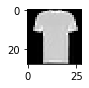

In [5]:
plt.figure(figsize=(1,1))
plt.imshow(X_train[0], cmap="gray")
plt.show()

If we look at the corresponding label from our `y` data, we can see that the label `0` corresponds to shirts:

In [6]:
print(y_train[0])

0.0


Similarly, we can visualize an image of trousers:

label: 1.0


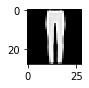

In [7]:
print("label:", y_train[105])
plt.figure(figsize=(1,1))
plt.imshow(X_train[105], cmap="gray")
plt.show()

We can see that the training set is balanced - there are 100 entries of each of the two classes in the training set:

In [8]:
classes, counts = np.unique(y_train, return_counts=True)
print(classes)
print(counts)

[0. 1.]
[100 100]


## Transform the Data

The image data that we've loaded needs to be reorganized in order to be used for training a neural net. We'll need this helper function:

In [9]:
def images_to_rgb_and_resized(img_arr, size_tuple):
    w_channels = img_arr[..., np.newaxis]
    as_tensor = tf.convert_to_tensor(w_channels)
    rgb = tf.image.grayscale_to_rgb(as_tensor)
    return tf.image.resize(rgb, size_tuple)

The function above converts our grayscale images to RGB color format (though it will still look gray) and resizes it to the specified size. We'll resize our images to `(96,96)` since the complex neural net we will use as the basis of our transfer learning process expects images with these dimensions. We can prepare our `X_train` dataset as follows:

In [10]:
X_train_processed = images_to_rgb_and_resized(X_train, (96,96))

In [13]:
X_train_processed[0]

<tf.Tensor: shape=(96, 96, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


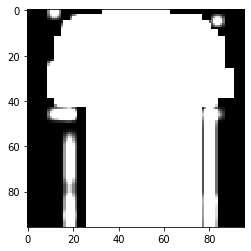

In [14]:
plt.imshow(X_train_processed[0])

In [18]:
!conda list

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main    conda-forge
absl-py                   0.9.0                    pypi_0    pypi
alembic                   1.3.1                      py_0    conda-forge
astor                     0.8.1                    pypi_0    pypi
async_generator           1.10                       py_0    conda-forge
attrs                     19.3.0                     py_0    conda-forge
backcall                  0.1.0                      py_0    conda-forge
bleach                    3.1.0                      py_0    conda-forge
blinker                   1.4                        py_1    conda-forge
ca-certificates           2019.11.28           hecc5488_0    conda-forge
cachetools                4.0.0                    pypi_0    pypi
certifi                   2019.11.28               py37_0    conda-forge
certipy                   0.1.3    

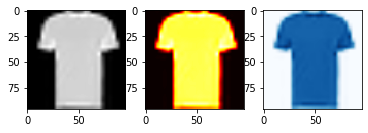

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(X_train_processed[0][:,:,0], cmap="gray")
ax[1].imshow(X_train_processed[0][:,:,1], cmap="hot")
ax[2].imshow(X_train_processed[0][:,:,2], cmap="Blues")

## Download the Pretrained Model

We are going to use a pre-trained copy of the `MobileNetV2` neural network as the basis of our model for classifying the images above. We can import it as follows:

In [40]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

It is straightforward to create our `base_model` as an instance of `MobileNetV2`:

In [41]:
base_model = MobileNetV2(
    include_top=False,
    pooling='avg',
    input_shape=(96,96,3)
)

9412608/9406464 [==============================] - 0s 0us/step


We can use the `summary` method to get a list of layers in our `base_model` - as you can see, it is very complex:

In [42]:
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

However, the key benefit of transfer learning is that we can (for the most part) ignore all of this complexity. Instead, we just need to worry about the output of the final layer of `base_model`. Normally, this output layer would be some sort of classification layer that converts all of the image features identified by our model into a classfication decision - "is this image a shirt or a pair of trousers?" However, since we specified `include_top=False` when we constructed `base_model`, this outer layer of our `MobileNetV2` model has been removed. This means that the output of `base_model` will be an array of features where each row is an image from our dataset and each column is an image feature that has been quantified by the action of the many deep layers of the model:

In [43]:
features = base_model.predict(X_train_processed)
n_features = features.shape[1]
features.shape

(200, 1280)

The essence of transfer learning is the following: we are going to use these features, rather than the raw images themselves, as the input for training our classifier.

## Train the Output Layer of our Classifier 

We're now going to train a single-layer neural network that uses the features we generated above as inputs. From these features, our output layer will produce a pair of *class scores* - a pair of probabilities that the image under consideration is either a shirt or a pair of trousers, respectively:

In [44]:
from tensorflow import keras

model_output = keras.Sequential()
model_output.add(
    keras.layers.Dense(
        input_shape=(n_features,),
        units=2,
        activation="softmax"
    )
)

Let's configure for training - since this is a classification problem, we'll use `categorical_crossentropy` for our loss function: 

In [45]:
model_output.compile(
    optimizer="sgd",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

We can train this single layer as follows:

In [46]:
from tensorflow.keras.utils import to_categorical

model_output.fit(
    features, 
    to_categorical(y_train),
    epochs=5
)

Train on 200 samples
Epoch 1/5
200/200 [==============================] - 0s 2ms/sample - loss: 1.1018 - accuracy: 0.6800
Epoch 2/5
200/200 [==============================] - 0s 64us/sample - loss: 0.0740 - accuracy: 0.9650
Epoch 3/5
200/200 [==============================] - 0s 355us/sample - loss: 0.0666 - accuracy: 0.9700
Epoch 4/5
200/200 [==============================] - 0s 67us/sample - loss: 0.0582 - accuracy: 0.9800
Epoch 5/5
200/200 [==============================] - 0s 59us/sample - loss: 0.0467 - accuracy: 0.9900


After a few epochs, our model is achieving 99% accuracy on the training set!

## Simplifying Our Code

We can combine our `base_model` and `model_output` together for convenience:

In [47]:
model_combined = keras.Sequential([
  base_model,
  model_output.layers[-1]
])

The `model_combined` that we created above now contains the entire pipeline - it accepts images as input and returns its classification of the image - the intermediate computation of the features using `MobileNetV2` has been hidden under the hood. 

It is easy to verify that the combined and step-by-step approaches give identical performance:

In [48]:
np.all(model_combined.predict(X_train_processed) == model_output.predict(features))

True

As our final exercise, we're going to evaluate the accuracy of `model_combined` on the test set - even though we aren't retraining the model, we still need to `compile` it prior to evaluation:

In [55]:
model_combined.compile(
    optimizer="sgd",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

<span style="color:blue;font-weight:bold">Exercise</span>: We now need to verify that our model achieves high accuracy on data that was not in its training set, so that we can be confident that it will generalize well to new images. Perform the following tasks:

* Call `images_to_rgb_and_resized` on the test set with the appropriate size of `(96,96)` and store the result in `X_test_processed`. 
* Call `model_combined.evaluate` on `X_test_processed` and `y_test`, with `y_test` appropriately converted using `to_categorical` as shown above. Store the return value in the variable `evaluation_result` and call `print(evaluation_result)`

In [57]:
X_test_processed = images_to_rgb_and_resized(X_test, size_tuple=(96,96))
evaluation_result = model_combined.evaluate(X_test_processed, tf.keras.utils.to_categorical(y_test))

40/40 [==============================] - 2s 45ms/sample - loss: 0.0143 - accuracy: 1.0000


In [57]:
check_variable_definition("X_test_processed")
check_variable_definition("evaluation_result")
assert X_test_processed.shape == (40, 96, 96, 3), "Your <code>X_test_processed</code> has the wrong shape - check your call to <code>images_to_rgb_and_resized</code>"
assert evaluation_result[1] == 1.0, "Your evaluation result did not match what was expected - double check your call to <code>evaluate</code>"
success()

In [58]:
evaluation_result

[0.014281210117042064, 1.0]

[0.9882586  0.01174134]


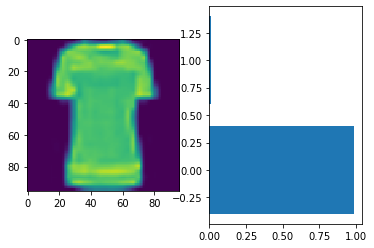

[0.73279804 0.267202  ]


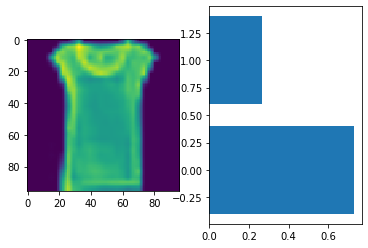

[0.99716634 0.00283361]


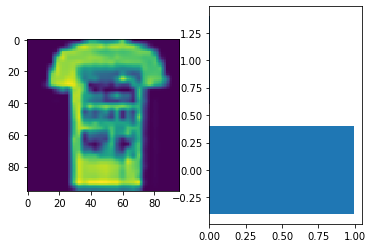

[0.99310124 0.00689873]


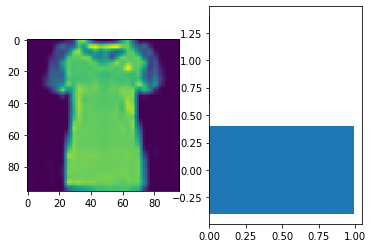

[0.99295723 0.00704281]


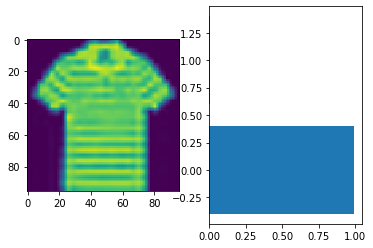

[0.99551743 0.00448256]


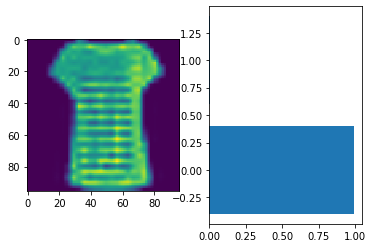

[0.9912464  0.00875359]


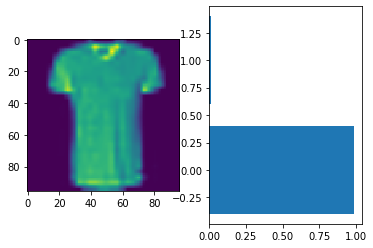

[0.9927618 0.0072382]


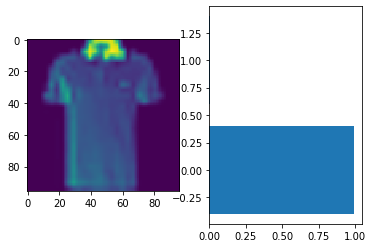

[0.99388266 0.00611732]


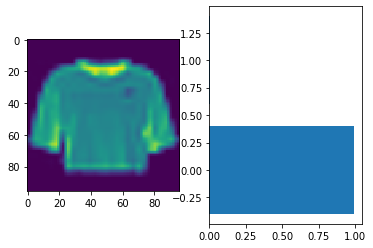

[0.9989157  0.00108432]


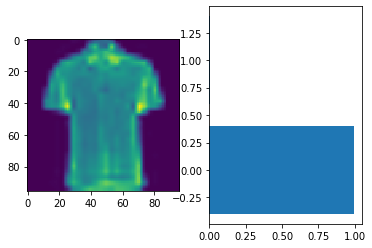

[0.9921685  0.00783152]


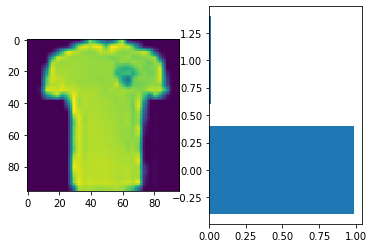

[0.99665475 0.00334518]


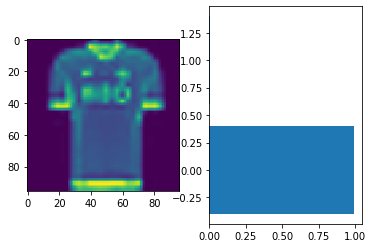

[0.9939614  0.00603863]


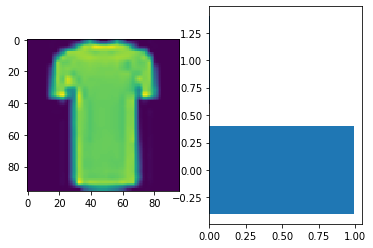

[0.96949524 0.03050479]


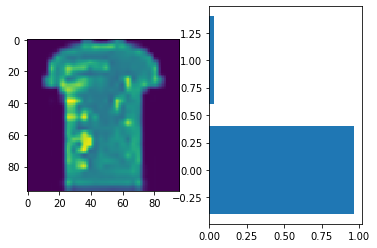

[0.9838585  0.01614145]


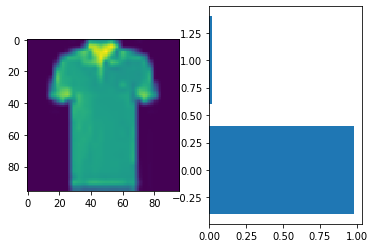

[0.9974732  0.00252685]


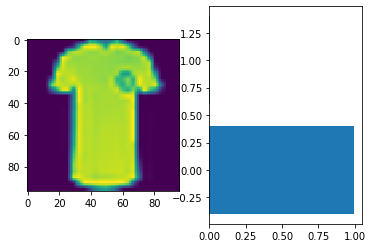

[0.9915393  0.00846069]


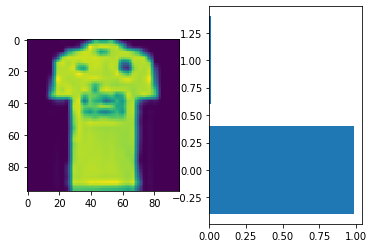

[0.9917926 0.0082074]


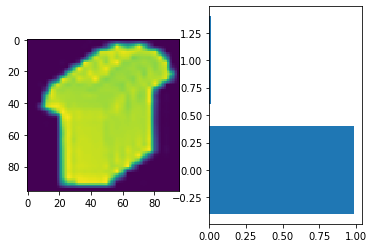

[0.9931467  0.00685322]


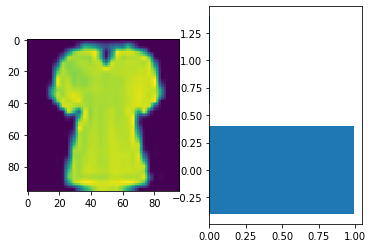

[0.9926191  0.00738087]


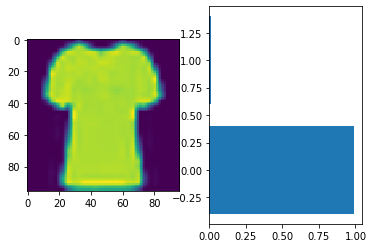

[2.6562027e-04 9.9973434e-01]


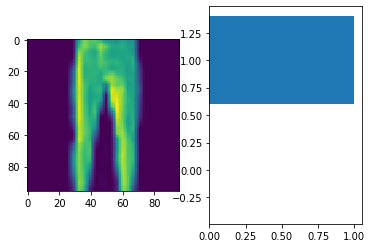

[0.00415066 0.9958494 ]


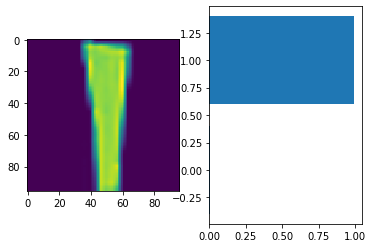

[0.00124858 0.9987514 ]


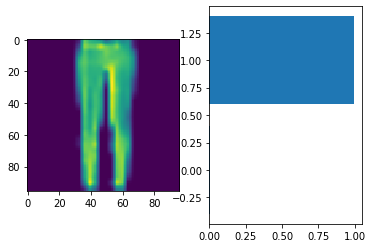

[0.00185299 0.998147  ]


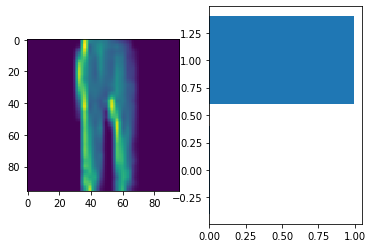

[4.4529248e-04 9.9955469e-01]


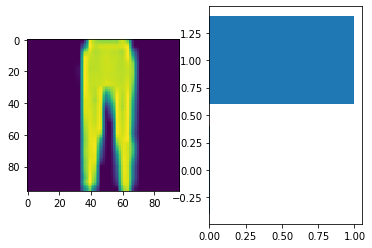

[0.00616878 0.99383116]


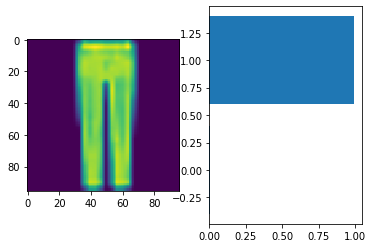

[0.01223187 0.9877681 ]


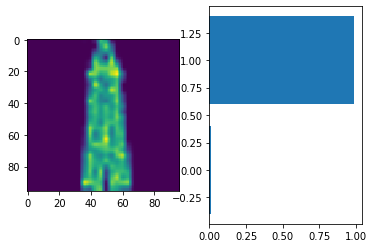

[0.00389266 0.9961073 ]


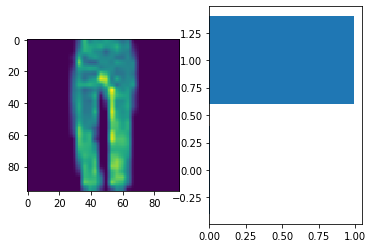

[0.00417838 0.9958216 ]


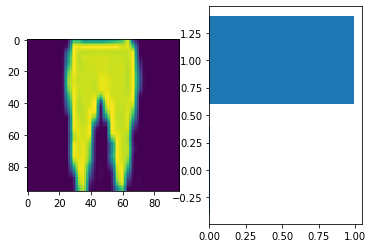

[0.00266565 0.99733436]


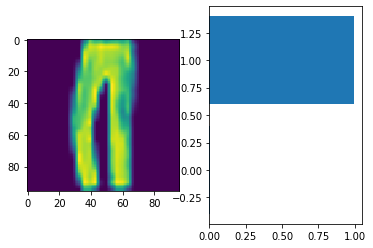

[0.01546377 0.98453623]


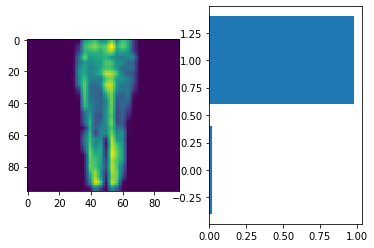

[0.0032523  0.99674773]


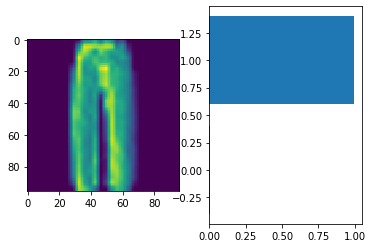

[0.00488544 0.99511456]


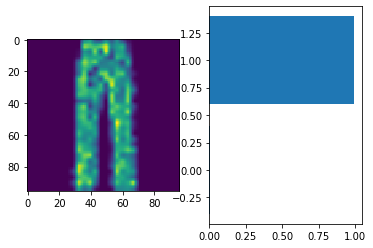

[0.00358875 0.99641126]


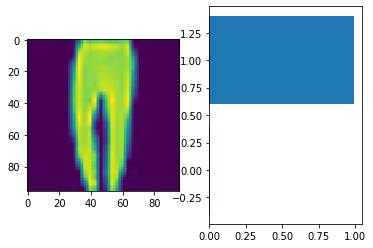

[7.8593555e-04 9.9921405e-01]


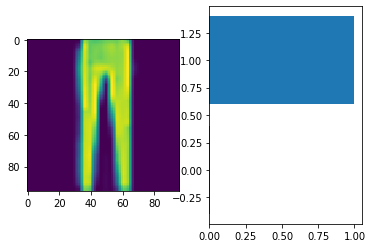

[0.00399652 0.99600345]


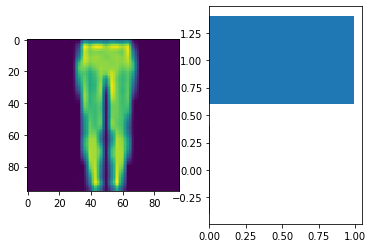

[0.0326095  0.96739054]


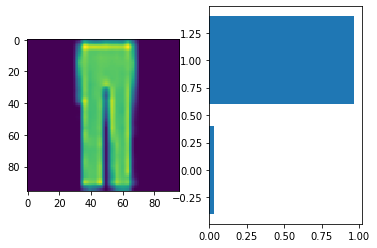

[0.00100496 0.998995  ]


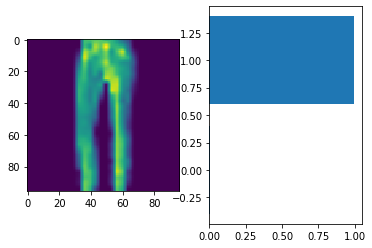

[6.1926054e-04 9.9938071e-01]


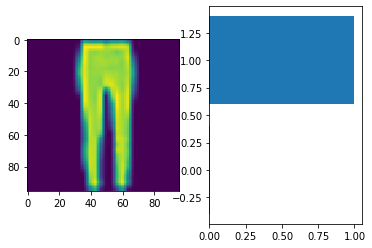

[0.00174654 0.9982534 ]


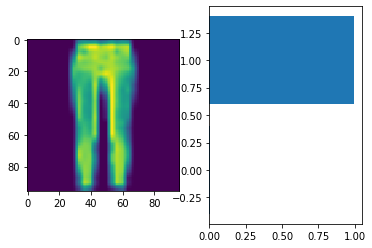

In [80]:
for image in X_test_processed:
    
    probs = model_combined.predict(image.numpy().reshape(-1,96,96,3))
    print(probs.squeeze())
    fig,ax = plt.subplots(ncols=2)
    ax[0].imshow(image[:,:,0])
    ax[1].barh(np.arange(len(probs.squeeze())), probs.squeeze())
    plt.show()
    

The first number in the list above is the loss function value that our model produced when evaluated on the test set. It is difficult to interpret in this case, so we may ignore it. The second number in the list above is the accuracy value we are looking for - in this case, our model has classified all 20 images correctly and achieves a perfect score! 

Note: real image classification problems require much larger training and test sets, so you shouldn't expect to get a perfect score in more "real world" projects. 

## Further Reading

* See [here](https://www.tensorflow.org/tutorials/images/transfer_learning) for further discussion of transfer learning using Tensorflow
* The following code snippet will allow you to load the full Fashion MNIST dataset for your own experiments:

```
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
```